In [1]:
# importing librarires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# dataframe creation
df=pd.read_csv('perrin-freres-monthly-champagne-sales.csv')

In [7]:
df.columns=['Month','Sales']
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [8]:
df.tail()

,Month,Sales
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


look the last 2 columns have null values, so we will remove them

In [12]:
df.drop([105, 106], errors="ignore", inplace=True)

In [13]:
df.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [20]:
df.rename(columns=lambda x: x.strip(), inplace=True)
df.index = pd.to_datetime(df.index)
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<Axes: xlabel='Month'>

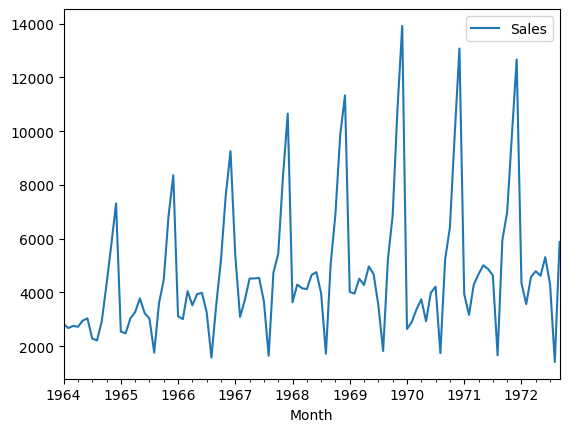

In [22]:
## Data Visualisation
df.plot()

In [27]:
# Adfuller
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Sales'])

In [34]:
# Hypothesis Testing
def adfuller_test(sales):
    result=adfuller(sales)
    labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations on Used']
    for value,label in zip(result,labels):
        print((label +':'+str(value)))
    if result[1]<=0.05:
        print("strong evidence against the null hypothesis. Reject the null hypothesis. Data has no unit root and is stationary")
    else :
        print("weak evidence against the null hypothesis.  Data has a unit root indication it is non stationary")

In [35]:
adfuller_test(df['Sales'])

ADF Test Statistic:-1.8335930563276217
p-value:0.3639157716602457
#Lags Used:11
Number of Observations on Used:93
weak evidence against the null hypothesis.  Data has a unit root indication it is non stationary


In [37]:
df['Seasonal Difference']=df['Sales']-df['Sales'].shift(12)
df.head(14)

,Sales,Seasonal Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
1964-06-01,3036.0,NaN
1964-07-01,2282.0,NaN
1964-08-01,2212.0,NaN
1964-09-01,2922.0,NaN


In [39]:
adfuller_test(df['Seasonal Difference'].dropna())

ADF Test Statistic:-7.626619157213166
p-value:2.060579696813663e-11
#Lags Used:0
Number of Observations on Used:92
strong evidence against the null hypothesis. Reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

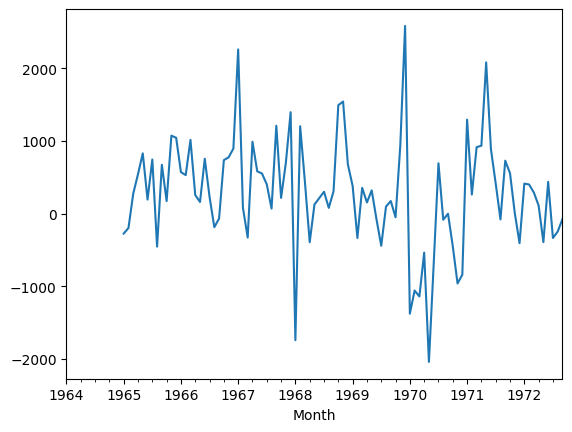

In [41]:
df['Seasonal Difference'].plot()

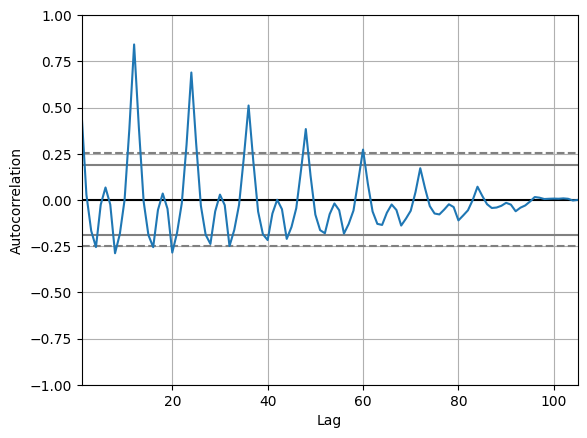

In [42]:
# AR Model
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sales'])
plt.show()

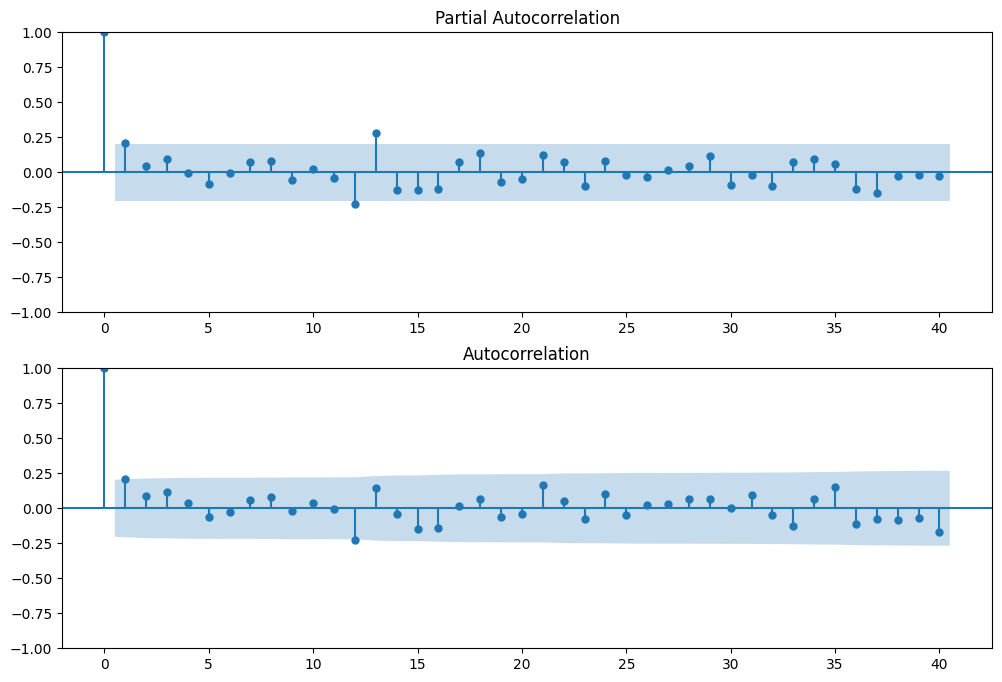

In [49]:
import statsmodels.api as sm
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_pacf(df['Seasonal Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(df['Seasonal Difference'].iloc[13:],lags=40,ax=ax2)

In [55]:
# ARIMA
# Ensure DateTimeIndex has a frequency
# df = df.asfreq('MS')   # Month Start freq (change if needed)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df["Sales"], order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Sat, 16 Aug 2025   AIC                           1911.627
Time:                        16:47:45   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.472      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

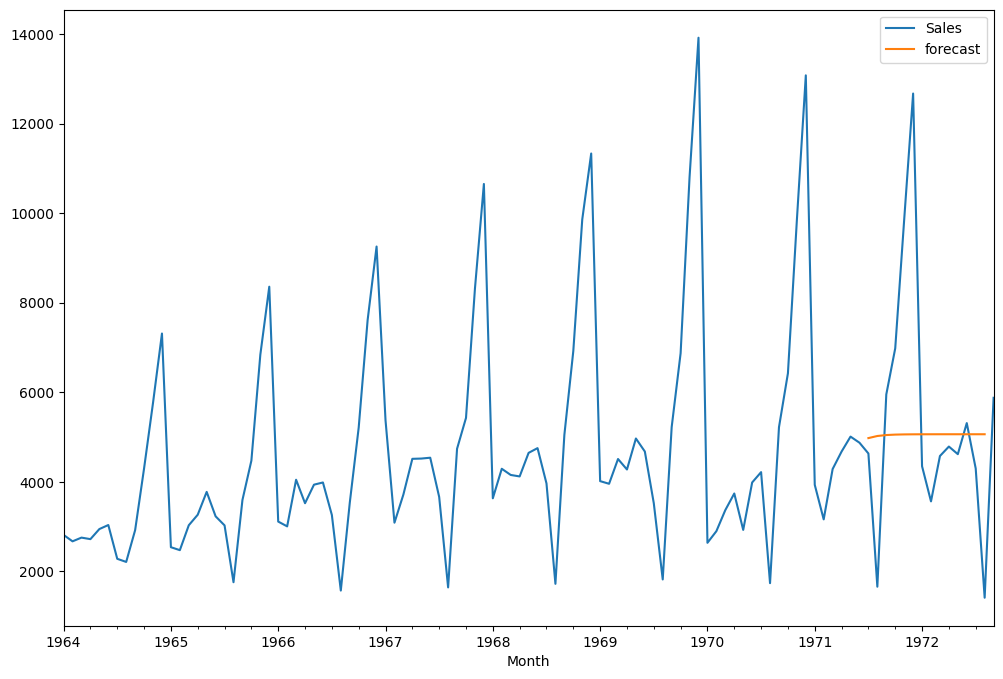

In [56]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [58]:
# SARIMA Model
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

<Axes: xlabel='Month'>

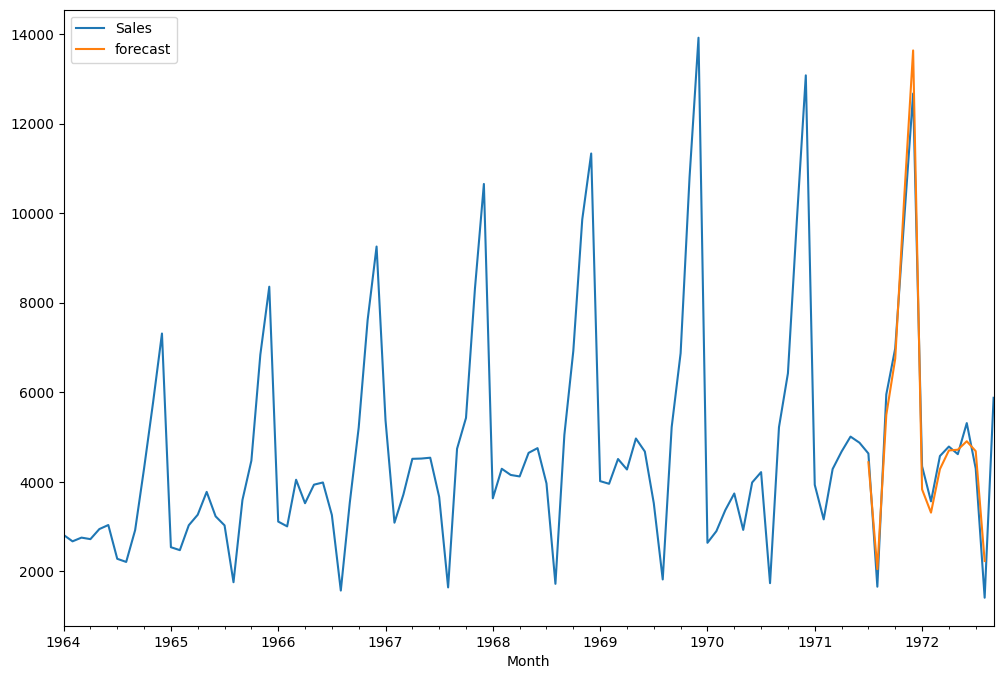

In [59]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [61]:
# predicting the future
from pandas.tseries.offsets import DateOffset

#Here USING FOR LOOP we are adding some additional data for prediction purpose:

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [63]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [64]:
#CONCATE THE ORIGINAL AND THE NEWLY CREATED DATASET FOR VISUALIZATION PURPOSE:
future_df=pd.concat([df,future_datest_df])

<Axes: >

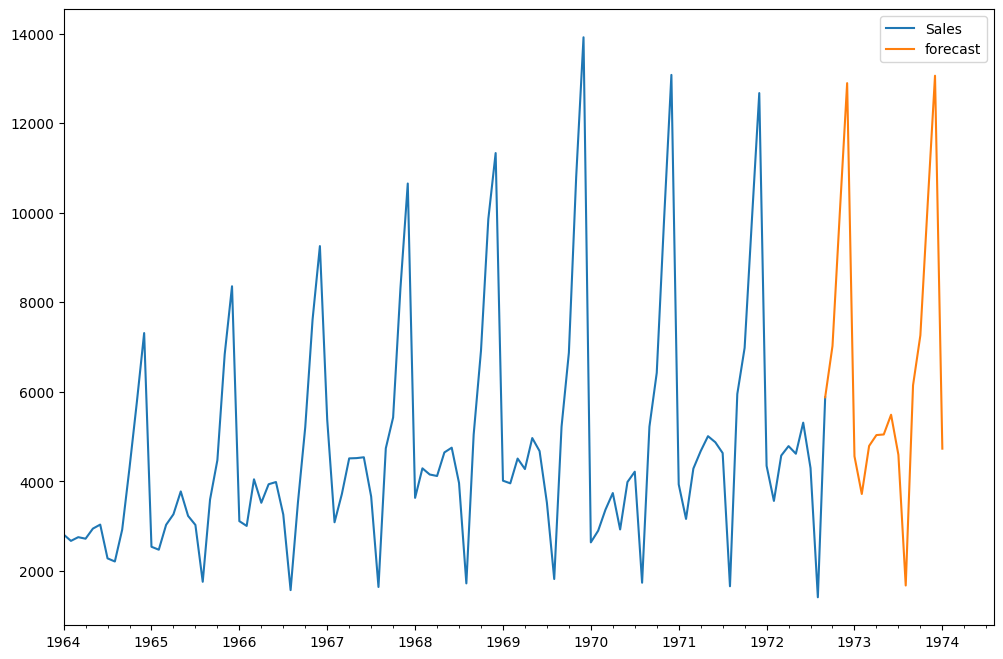

In [65]:
#PREDICT
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))